In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from torchvision import transforms
from collections import OrderedDict
import torchvision
from torch.quantization import QuantStub, DeQuantStub
from tqdm import tqdm
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.CenterCrop((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.CenterCrop((256, 256)),
    transforms.ToTensor(),
    
])

train_dataset = torchvision.datasets.VOCSegmentation('/scratch/jp5881/voc', year="2012",download=False, image_set="train",
                          transform=transform, target_transform=target_transform,)
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=64)


In [3]:
transform = transforms.Compose([
    transforms.CenterCrop((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.CenterCrop((256, 256)),
    transforms.ToTensor(),
    
])

test_dataset = torchvision.datasets.VOCSegmentation('/scratch/jp5881/voc', year="2012",download=False, image_set="val",
                          transform=transform, target_transform=target_transform,)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=1)

In [4]:
class UNet(nn.Module):

    def __init__(self, in_channels, out_channels, init_features=32):
        super(UNet, self).__init__()
        
        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
       
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        bottleneck = self.bottleneck(self.pool4(enc4))
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        out=torch.sigmoid(self.conv(dec1))
       
        return out 

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [14]:
loss = torch.nn.CrossEntropyLoss()

net=torch.load("648")
net.cuda()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
epochs=20
ll=[]
j=0
for epoch in tqdm(range(epochs)):
    net.train()
    epoch_loss = 0
    j+=1
    if(j==50):
        j=0
        torch.save(net,str(epoch+99))
        plt.plot(ll)
    for batch in (train_loader):
        inp,out=batch
        inp,out = inp.cuda(),out.cuda()
        optimizer.zero_grad()
        output=net(inp)
        
        
        target = torch.argmax(out, dim=1)
        
        loss_t=loss(output,target)
        epoch_loss+=loss_t
        loss_t.backward()
        optimizer.step()
        scheduler.step(loss_t)
    ll.append(epoch_loss)

100%|██████████| 20/20 [06:52<00:00, 20.64s/it]


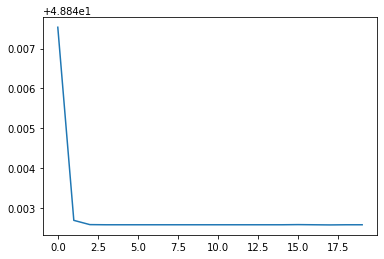

In [15]:
plt.plot(ll)

In [11]:
torch.save(net,"final")

In [12]:
def intersectionAndUnion(imPred, imLab, numClass,ignore_index):
    imPred = np.asarray(imPred).copy()
    imLab = np.asarray(imLab).copy()

    
    imPred[(imLab == ignore_index)[0]] = ignore_index
    intersection = imPred * (imPred == imLab)
    (area_intersection, _) = np.histogram(
        intersection, bins=numClass, range=(1, numClass))
    (area_pred, _) = np.histogram(imPred, bins=numClass, range=(1, numClass))
    (area_lab, _) = np.histogram(imLab, bins=numClass, range=(1, numClass))
    area_union = area_pred + area_lab - area_intersection

    return (area_intersection, area_union)

In [13]:
miou=0
model=torch.load("648")
model.cuda()
model.eval()


for batch in tqdm(test_loader):
    inp,tar=batch
    inp=inp.cuda()
    tar=tar.cuda()
    
    output = model(inp)
    
    output_predictions_t = output[0].argmax(0)
    
    a,b=intersectionAndUnion(output_predictions_t.cpu(),tar[0].cpu()*255,21,255)
    
    iou = a/(b+1e-6)
    miou+=iou.mean()
    

100%|██████████| 1449/1449 [00:21<00:00, 68.19it/s]


In [9]:
print(miou)

0.0


In [10]:
loss = torch.nn.CrossEntropyLoss()
net=mm
net.cuda()
optimizer = optim.Adam(net.parameters(), lr=1e-5)
epochs=10
ll=[]
for epoch in tqdm(range(epochs)):
    net.train()
    epoch_loss = 0
    for batch in (train_loader):
        inp,out=batch
        inp,out = inp.cuda(),out.cuda()
        optimizer.zero_grad()
        output=net(inp)
        target = torch.argmax(out, dim=1)
        loss_t=loss(output,target)
        epoch_loss+=loss_t
        loss_t.backward()
        optimizer.step()
    ll.append(epoch_loss)

NameError: name 'mm' is not defined

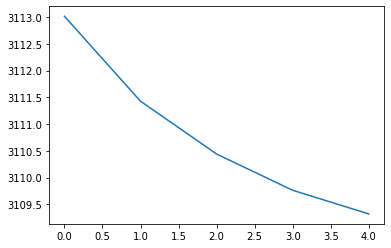

In [25]:
plt.plot(ll)

In [21]:
net.encoder1.qconfig=None
#net.encoder3.qconfig=None
model=net
model.qconfig = torch.quantization.get_default_qconfig('qnnpack')
model_prepared = torch.quantization.prepare(model)
model_prepared.eval()
gg=torch.quantization.convert(model_prepared.cpu(), inplace=True)

In [2]:
pytorch_total_params = sum(p.numel() for p in gg.parameters())
print(pytorch_total_params/10**6)

NameError: name 'gg' is not defined